# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

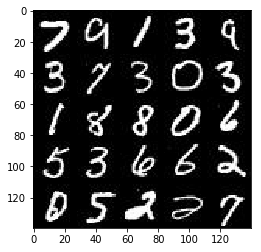

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

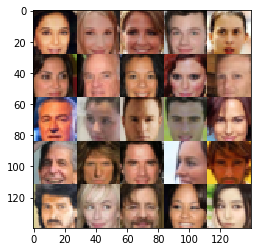

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input_images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    z_data = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    return real_input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    layer = images # 28x28x[1|3]
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Convolutions - output is 4x4x256
        for f in [64, 128, 256]:
            layer = tf.layers.conv2d(layer, f, 5, strides=2, padding='same')
            layer = leaky_relu(layer)
        # Flatten output and compute logits
        layer = tf.reshape(layer, (-1, 4*4*256))
        logits = tf.layers.dense(layer, 1)
        # Probability
        prob = tf.sigmoid(logits)

    return prob, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    
    with tf.variable_scope('generator', reuse=not is_train):
        # Reshape to start convolutions
        layer = tf.layers.dense(z, 3*3*512)
        layer = tf.reshape(layer, (-1, 3, 3, 512))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = leaky_relu(layer)
        # Transposed convolutions
        for f in [256, 128]:
            layer = tf.layers.conv2d_transpose(layer, f, 5, strides=2, padding='same')
            layer = tf.layers.batch_normalization(layer, training=is_train)
            layer = leaky_relu(layer)
        # Transposed convolution without batch_norm and activation
        layer = tf.layers.conv2d_transpose(layer, out_channel_dim, 6, strides=2, padding='valid')
        # Output squashed between -1 and 1
        output = tf.tanh(layer)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    # Forward passes to generate fake image and real/fake logits
    input_fake = generator(input_z, out_channel_dim, is_train=True)
    prob_real, logits_real = discriminator(input_real, reuse=False)
    prob_fake, logits_fake = discriminator(input_fake, reuse=True)
    # Discriminator's loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.zeros_like(logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    # Generator's loss    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.ones_like(logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_variables = tf.trainable_variables()
    d_variables = [v for v in trainable_variables if v.name.startswith('discriminator')]
    g_variables = [v for v in trainable_variables if v.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_optimizer = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_variables)
        g_optimizer = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_variables)
    
    return d_optimizer, g_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    out_channel_dim = len(data_image_mode)
    steps = 0
    
    real_images, z, lr = model_inputs(28, 28, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(real_images, z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Sample for z
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_images: batch_images, 
                                               z: batch_z, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={real_images: batch_images, 
                                               z: batch_z, 
                                               lr: learning_rate})
                # Monitor losses
                if steps % 20 == 0:
                    d_train_loss = sess.run(d_loss, feed_dict={real_images: batch_images,
                                                               z: batch_z,
                                                               lr: learning_rate})
                    g_train_loss = sess.run(g_loss, feed_dict={real_images: batch_images,
                                                               z: batch_z,
                                                               lr: learning_rate})
                    print('Epoch {}/{}, '.format(epoch_i+1, epoch_count),
                          'Step {}\t'.format(steps),
                          'Discriminator loss: {:.4f}\t'.format(d_train_loss),
                          'Generator loss: {:.4f}\t'.format(g_train_loss))
                # Monitor fake images
                if steps % 100 == 0:
                    show_generator_output(sess, 36, z, out_channel_dim, data_image_mode)
        # Show last step's result
        show_generator_output(sess, 36, z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2,  Step 20	 Discriminator loss: 1.2605	 Generator loss: 1.0212	
Epoch 1/2,  Step 40	 Discriminator loss: 1.2619	 Generator loss: 0.8137	
Epoch 1/2,  Step 60	 Discriminator loss: 1.1254	 Generator loss: 1.4350	
Epoch 1/2,  Step 80	 Discriminator loss: 1.4294	 Generator loss: 1.1798	
Epoch 1/2,  Step 100	 Discriminator loss: 1.0507	 Generator loss: 1.5913	


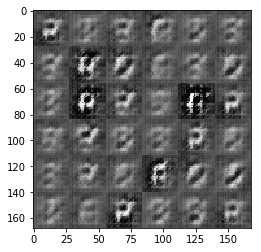

Epoch 1/2,  Step 120	 Discriminator loss: 1.1078	 Generator loss: 0.9923	
Epoch 1/2,  Step 140	 Discriminator loss: 1.0939	 Generator loss: 1.7260	
Epoch 1/2,  Step 160	 Discriminator loss: 3.2966	 Generator loss: 4.8566	
Epoch 1/2,  Step 180	 Discriminator loss: 1.1606	 Generator loss: 1.4614	
Epoch 1/2,  Step 200	 Discriminator loss: 1.0090	 Generator loss: 1.2183	


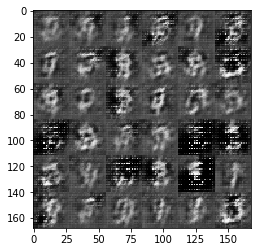

Epoch 1/2,  Step 220	 Discriminator loss: 0.8111	 Generator loss: 1.6078	
Epoch 1/2,  Step 240	 Discriminator loss: 1.1593	 Generator loss: 0.7214	
Epoch 1/2,  Step 260	 Discriminator loss: 0.8337	 Generator loss: 2.4585	
Epoch 1/2,  Step 280	 Discriminator loss: 1.3398	 Generator loss: 3.1555	
Epoch 1/2,  Step 300	 Discriminator loss: 0.6018	 Generator loss: 3.2011	


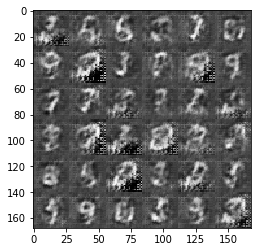

Epoch 1/2,  Step 320	 Discriminator loss: 1.0796	 Generator loss: 2.3204	
Epoch 1/2,  Step 340	 Discriminator loss: 0.9072	 Generator loss: 1.0849	
Epoch 1/2,  Step 360	 Discriminator loss: 1.7024	 Generator loss: 0.3398	
Epoch 1/2,  Step 380	 Discriminator loss: 0.7320	 Generator loss: 1.8132	
Epoch 1/2,  Step 400	 Discriminator loss: 0.8337	 Generator loss: 1.1769	


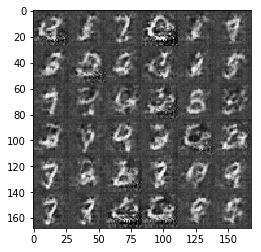

Epoch 1/2,  Step 420	 Discriminator loss: 1.7453	 Generator loss: 0.3226	
Epoch 1/2,  Step 440	 Discriminator loss: 1.2369	 Generator loss: 0.6291	
Epoch 1/2,  Step 460	 Discriminator loss: 0.9020	 Generator loss: 1.0056	
Epoch 1/2,  Step 480	 Discriminator loss: 0.8091	 Generator loss: 2.0773	
Epoch 1/2,  Step 500	 Discriminator loss: 0.8265	 Generator loss: 1.2004	


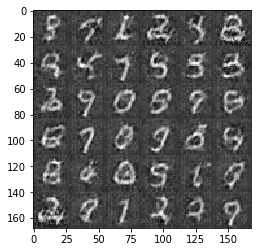

Epoch 1/2,  Step 520	 Discriminator loss: 0.8353	 Generator loss: 1.4418	
Epoch 1/2,  Step 540	 Discriminator loss: 0.8250	 Generator loss: 2.5069	
Epoch 1/2,  Step 560	 Discriminator loss: 1.4431	 Generator loss: 0.4967	
Epoch 1/2,  Step 580	 Discriminator loss: 0.6271	 Generator loss: 6.0928	
Epoch 1/2,  Step 600	 Discriminator loss: 0.6959	 Generator loss: 1.9661	


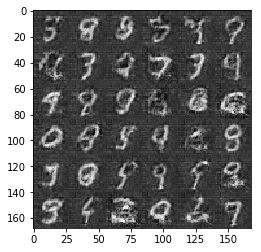

Epoch 1/2,  Step 620	 Discriminator loss: 0.8365	 Generator loss: 1.5602	
Epoch 1/2,  Step 640	 Discriminator loss: 0.3859	 Generator loss: 6.0124	
Epoch 1/2,  Step 660	 Discriminator loss: 1.1092	 Generator loss: 4.0820	
Epoch 1/2,  Step 680	 Discriminator loss: 1.0868	 Generator loss: 0.7438	
Epoch 1/2,  Step 700	 Discriminator loss: 0.7198	 Generator loss: 1.7663	


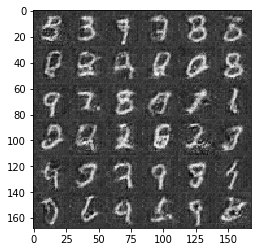

Epoch 1/2,  Step 720	 Discriminator loss: 1.2464	 Generator loss: 0.6245	
Epoch 1/2,  Step 740	 Discriminator loss: 0.5603	 Generator loss: 5.9436	
Epoch 1/2,  Step 760	 Discriminator loss: 0.8457	 Generator loss: 1.4011	
Epoch 1/2,  Step 780	 Discriminator loss: 0.9011	 Generator loss: 4.7963	
Epoch 1/2,  Step 800	 Discriminator loss: 0.6360	 Generator loss: 6.8008	


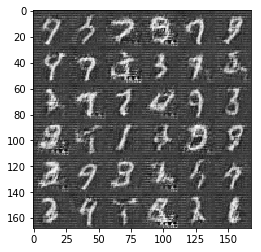

Epoch 1/2,  Step 820	 Discriminator loss: 0.8343	 Generator loss: 1.3176	
Epoch 1/2,  Step 840	 Discriminator loss: 0.7460	 Generator loss: 1.4970	
Epoch 1/2,  Step 860	 Discriminator loss: 0.7019	 Generator loss: 1.9210	
Epoch 1/2,  Step 880	 Discriminator loss: 1.1449	 Generator loss: 0.7510	
Epoch 1/2,  Step 900	 Discriminator loss: 0.4171	 Generator loss: 4.9542	


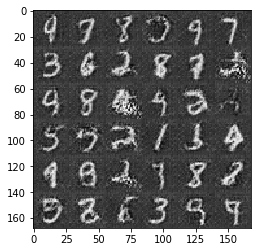

Epoch 1/2,  Step 920	 Discriminator loss: 0.5383	 Generator loss: 3.3380	
Epoch 2/2,  Step 940	 Discriminator loss: 0.4662	 Generator loss: 2.8430	
Epoch 2/2,  Step 960	 Discriminator loss: 0.6458	 Generator loss: 5.5831	
Epoch 2/2,  Step 980	 Discriminator loss: 1.1651	 Generator loss: 0.7698	
Epoch 2/2,  Step 1000	 Discriminator loss: 0.8923	 Generator loss: 1.0336	


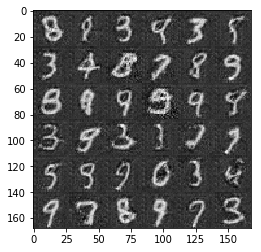

Epoch 2/2,  Step 1020	 Discriminator loss: 0.8002	 Generator loss: 3.1527	
Epoch 2/2,  Step 1040	 Discriminator loss: 0.4181	 Generator loss: 4.8980	
Epoch 2/2,  Step 1060	 Discriminator loss: 0.8859	 Generator loss: 1.0962	
Epoch 2/2,  Step 1080	 Discriminator loss: 1.0095	 Generator loss: 1.2183	
Epoch 2/2,  Step 1100	 Discriminator loss: 1.0335	 Generator loss: 0.9343	


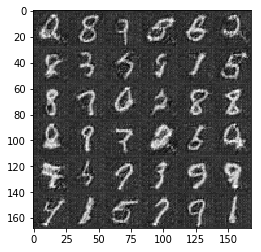

Epoch 2/2,  Step 1120	 Discriminator loss: 0.8986	 Generator loss: 1.0833	
Epoch 2/2,  Step 1140	 Discriminator loss: 0.5669	 Generator loss: 2.7995	
Epoch 2/2,  Step 1160	 Discriminator loss: 0.4764	 Generator loss: 2.8503	
Epoch 2/2,  Step 1180	 Discriminator loss: 1.4289	 Generator loss: 0.5562	
Epoch 2/2,  Step 1200	 Discriminator loss: 1.6136	 Generator loss: 0.4650	


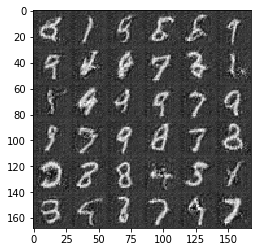

Epoch 2/2,  Step 1220	 Discriminator loss: 0.8136	 Generator loss: 1.4080	
Epoch 2/2,  Step 1240	 Discriminator loss: 0.8366	 Generator loss: 6.7553	
Epoch 2/2,  Step 1260	 Discriminator loss: 0.7755	 Generator loss: 1.6255	
Epoch 2/2,  Step 1280	 Discriminator loss: 0.8902	 Generator loss: 1.2423	
Epoch 2/2,  Step 1300	 Discriminator loss: 1.0066	 Generator loss: 1.0884	


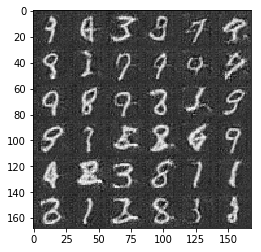

Epoch 2/2,  Step 1320	 Discriminator loss: 0.6986	 Generator loss: 5.6344	
Epoch 2/2,  Step 1340	 Discriminator loss: 0.5971	 Generator loss: 2.1478	
Epoch 2/2,  Step 1360	 Discriminator loss: 0.5519	 Generator loss: 4.0567	
Epoch 2/2,  Step 1380	 Discriminator loss: 0.4309	 Generator loss: 5.7843	
Epoch 2/2,  Step 1400	 Discriminator loss: 0.4043	 Generator loss: 4.1647	


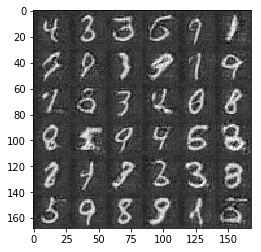

Epoch 2/2,  Step 1420	 Discriminator loss: 0.8331	 Generator loss: 1.3264	
Epoch 2/2,  Step 1440	 Discriminator loss: 0.6866	 Generator loss: 1.9995	
Epoch 2/2,  Step 1460	 Discriminator loss: 0.8755	 Generator loss: 1.2057	
Epoch 2/2,  Step 1480	 Discriminator loss: 0.8325	 Generator loss: 3.9599	
Epoch 2/2,  Step 1500	 Discriminator loss: 0.7164	 Generator loss: 1.5237	


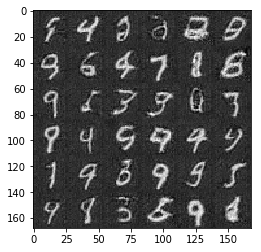

Epoch 2/2,  Step 1520	 Discriminator loss: 0.9601	 Generator loss: 0.9919	
Epoch 2/2,  Step 1540	 Discriminator loss: 0.6960	 Generator loss: 1.6517	
Epoch 2/2,  Step 1560	 Discriminator loss: 0.4739	 Generator loss: 4.0872	
Epoch 2/2,  Step 1580	 Discriminator loss: 0.5492	 Generator loss: 2.1981	
Epoch 2/2,  Step 1600	 Discriminator loss: 0.4157	 Generator loss: 4.2205	


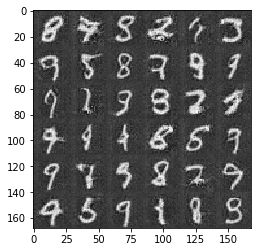

Epoch 2/2,  Step 1620	 Discriminator loss: 1.4084	 Generator loss: 0.4837	
Epoch 2/2,  Step 1640	 Discriminator loss: 0.6408	 Generator loss: 1.9319	
Epoch 2/2,  Step 1660	 Discriminator loss: 0.4318	 Generator loss: 3.2041	
Epoch 2/2,  Step 1680	 Discriminator loss: 0.7477	 Generator loss: 1.5956	
Epoch 2/2,  Step 1700	 Discriminator loss: 0.5259	 Generator loss: 2.9463	


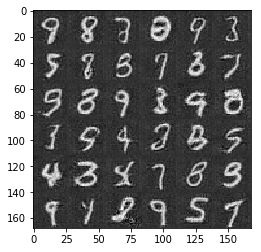

Epoch 2/2,  Step 1720	 Discriminator loss: 0.4357	 Generator loss: 3.2479	
Epoch 2/2,  Step 1740	 Discriminator loss: 0.7106	 Generator loss: 5.3779	
Epoch 2/2,  Step 1760	 Discriminator loss: 0.6307	 Generator loss: 1.9513	
Epoch 2/2,  Step 1780	 Discriminator loss: 0.8911	 Generator loss: 2.3591	
Epoch 2/2,  Step 1800	 Discriminator loss: 0.5052	 Generator loss: 2.6349	


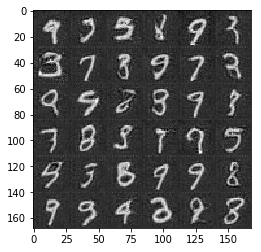

Epoch 2/2,  Step 1820	 Discriminator loss: 0.6695	 Generator loss: 2.4771	
Epoch 2/2,  Step 1840	 Discriminator loss: 0.6238	 Generator loss: 1.9045	
Epoch 2/2,  Step 1860	 Discriminator loss: 1.2621	 Generator loss: 0.6095	


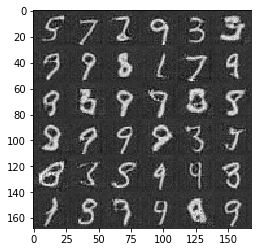

In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1,  Step 20	 Discriminator loss: 1.2101	 Generator loss: 0.7737	
Epoch 1/1,  Step 40	 Discriminator loss: 1.2666	 Generator loss: 0.8223	
Epoch 1/1,  Step 60	 Discriminator loss: 1.0200	 Generator loss: 1.8640	
Epoch 1/1,  Step 80	 Discriminator loss: 1.0315	 Generator loss: 1.5289	
Epoch 1/1,  Step 100	 Discriminator loss: 1.0990	 Generator loss: 1.5777	


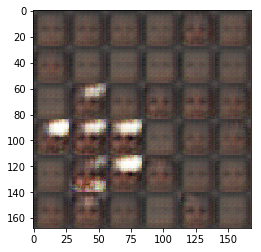

Epoch 1/1,  Step 120	 Discriminator loss: 2.1122	 Generator loss: 9.4083	
Epoch 1/1,  Step 140	 Discriminator loss: 0.8847	 Generator loss: 3.1872	
Epoch 1/1,  Step 160	 Discriminator loss: 0.9651	 Generator loss: 3.4271	
Epoch 1/1,  Step 180	 Discriminator loss: 0.8577	 Generator loss: 1.5778	
Epoch 1/1,  Step 200	 Discriminator loss: 0.9643	 Generator loss: 1.8661	


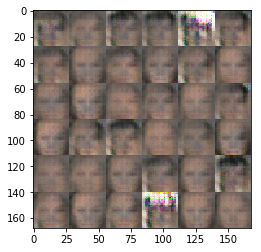

Epoch 1/1,  Step 220	 Discriminator loss: 1.6261	 Generator loss: 3.9599	
Epoch 1/1,  Step 240	 Discriminator loss: 1.1691	 Generator loss: 9.5638	
Epoch 1/1,  Step 260	 Discriminator loss: 1.1354	 Generator loss: 1.3112	
Epoch 1/1,  Step 280	 Discriminator loss: 1.2694	 Generator loss: 1.3870	
Epoch 1/1,  Step 300	 Discriminator loss: 1.3385	 Generator loss: 1.1048	


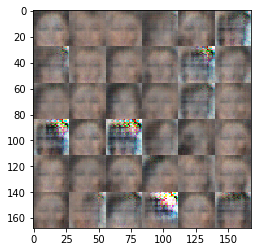

Epoch 1/1,  Step 320	 Discriminator loss: 1.2167	 Generator loss: 2.2723	
Epoch 1/1,  Step 340	 Discriminator loss: 1.2547	 Generator loss: 0.8399	
Epoch 1/1,  Step 360	 Discriminator loss: 1.3026	 Generator loss: 0.9720	
Epoch 1/1,  Step 380	 Discriminator loss: 1.5780	 Generator loss: 2.2174	
Epoch 1/1,  Step 400	 Discriminator loss: 1.2717	 Generator loss: 0.6008	


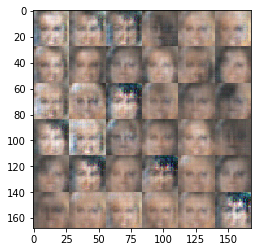

Epoch 1/1,  Step 420	 Discriminator loss: 1.0927	 Generator loss: 1.4445	
Epoch 1/1,  Step 440	 Discriminator loss: 1.2101	 Generator loss: 0.8774	
Epoch 1/1,  Step 460	 Discriminator loss: 1.0614	 Generator loss: 1.0665	
Epoch 1/1,  Step 480	 Discriminator loss: 1.2893	 Generator loss: 1.0310	
Epoch 1/1,  Step 500	 Discriminator loss: 1.1385	 Generator loss: 0.9353	


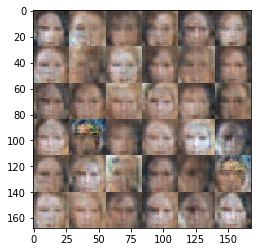

Epoch 1/1,  Step 520	 Discriminator loss: 1.1359	 Generator loss: 0.8068	
Epoch 1/1,  Step 540	 Discriminator loss: 1.1015	 Generator loss: 2.4581	
Epoch 1/1,  Step 560	 Discriminator loss: 0.8976	 Generator loss: 1.8421	
Epoch 1/1,  Step 580	 Discriminator loss: 0.8079	 Generator loss: 1.3051	
Epoch 1/1,  Step 600	 Discriminator loss: 1.4267	 Generator loss: 0.5886	


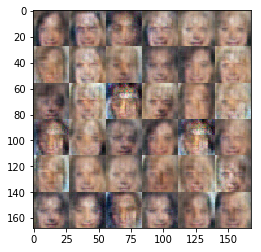

Epoch 1/1,  Step 620	 Discriminator loss: 1.5044	 Generator loss: 0.4543	
Epoch 1/1,  Step 640	 Discriminator loss: 0.9431	 Generator loss: 1.2280	
Epoch 1/1,  Step 660	 Discriminator loss: 0.9520	 Generator loss: 1.4796	
Epoch 1/1,  Step 680	 Discriminator loss: 1.0051	 Generator loss: 1.0810	
Epoch 1/1,  Step 700	 Discriminator loss: 0.9786	 Generator loss: 1.0998	


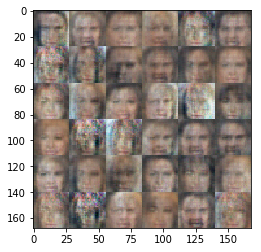

Epoch 1/1,  Step 720	 Discriminator loss: 1.0293	 Generator loss: 0.9087	
Epoch 1/1,  Step 740	 Discriminator loss: 1.0461	 Generator loss: 1.6770	
Epoch 1/1,  Step 760	 Discriminator loss: 1.0925	 Generator loss: 1.0448	
Epoch 1/1,  Step 780	 Discriminator loss: 1.1155	 Generator loss: 0.7314	
Epoch 1/1,  Step 800	 Discriminator loss: 1.1149	 Generator loss: 0.8018	


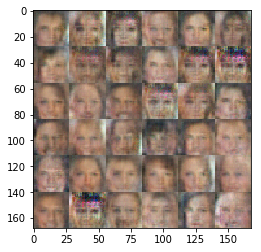

Epoch 1/1,  Step 820	 Discriminator loss: 1.0032	 Generator loss: 1.5346	
Epoch 1/1,  Step 840	 Discriminator loss: 0.8612	 Generator loss: 1.1733	
Epoch 1/1,  Step 860	 Discriminator loss: 0.9951	 Generator loss: 0.9420	
Epoch 1/1,  Step 880	 Discriminator loss: 1.2153	 Generator loss: 0.7026	
Epoch 1/1,  Step 900	 Discriminator loss: 0.9692	 Generator loss: 1.1866	


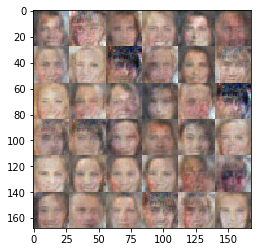

Epoch 1/1,  Step 920	 Discriminator loss: 1.1583	 Generator loss: 0.8027	
Epoch 1/1,  Step 940	 Discriminator loss: 1.1341	 Generator loss: 1.2126	
Epoch 1/1,  Step 960	 Discriminator loss: 1.0404	 Generator loss: 0.9824	
Epoch 1/1,  Step 980	 Discriminator loss: 1.5361	 Generator loss: 0.4600	
Epoch 1/1,  Step 1000	 Discriminator loss: 1.2302	 Generator loss: 1.1859	


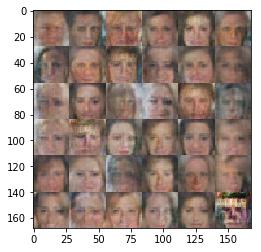

Epoch 1/1,  Step 1020	 Discriminator loss: 0.9361	 Generator loss: 3.1534	
Epoch 1/1,  Step 1040	 Discriminator loss: 1.0223	 Generator loss: 1.0819	
Epoch 1/1,  Step 1060	 Discriminator loss: 1.2724	 Generator loss: 1.7752	
Epoch 1/1,  Step 1080	 Discriminator loss: 1.2791	 Generator loss: 0.6545	
Epoch 1/1,  Step 1100	 Discriminator loss: 0.9784	 Generator loss: 1.7679	


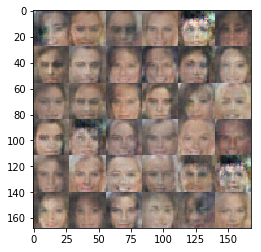

Epoch 1/1,  Step 1120	 Discriminator loss: 1.0952	 Generator loss: 1.0788	
Epoch 1/1,  Step 1140	 Discriminator loss: 1.0674	 Generator loss: 1.4966	
Epoch 1/1,  Step 1160	 Discriminator loss: 1.3972	 Generator loss: 0.6411	
Epoch 1/1,  Step 1180	 Discriminator loss: 1.4253	 Generator loss: 1.6126	
Epoch 1/1,  Step 1200	 Discriminator loss: 1.4676	 Generator loss: 0.5467	


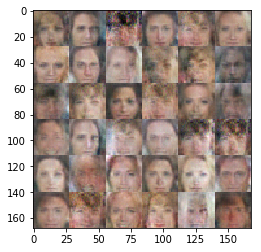

Epoch 1/1,  Step 1220	 Discriminator loss: 0.9368	 Generator loss: 1.4769	
Epoch 1/1,  Step 1240	 Discriminator loss: 1.1332	 Generator loss: 0.9048	
Epoch 1/1,  Step 1260	 Discriminator loss: 1.0446	 Generator loss: 0.9602	
Epoch 1/1,  Step 1280	 Discriminator loss: 1.3159	 Generator loss: 0.6979	
Epoch 1/1,  Step 1300	 Discriminator loss: 1.4403	 Generator loss: 0.5935	


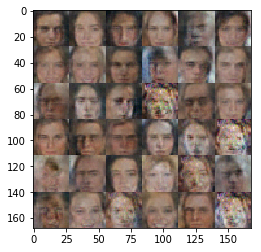

Epoch 1/1,  Step 1320	 Discriminator loss: 1.0469	 Generator loss: 0.9114	
Epoch 1/1,  Step 1340	 Discriminator loss: 1.0514	 Generator loss: 1.1089	
Epoch 1/1,  Step 1360	 Discriminator loss: 1.1598	 Generator loss: 0.9542	
Epoch 1/1,  Step 1380	 Discriminator loss: 1.2689	 Generator loss: 0.7131	
Epoch 1/1,  Step 1400	 Discriminator loss: 1.1477	 Generator loss: 0.9479	


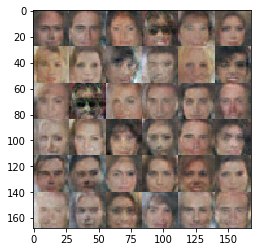

Epoch 1/1,  Step 1420	 Discriminator loss: 1.2762	 Generator loss: 0.6480	
Epoch 1/1,  Step 1440	 Discriminator loss: 1.3501	 Generator loss: 0.6325	
Epoch 1/1,  Step 1460	 Discriminator loss: 1.0595	 Generator loss: 1.1372	
Epoch 1/1,  Step 1480	 Discriminator loss: 1.1355	 Generator loss: 1.4951	
Epoch 1/1,  Step 1500	 Discriminator loss: 1.0779	 Generator loss: 1.2989	


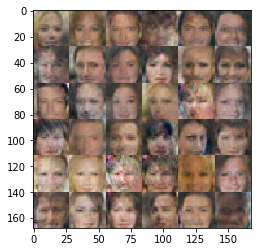

Epoch 1/1,  Step 1520	 Discriminator loss: 1.1418	 Generator loss: 0.9667	
Epoch 1/1,  Step 1540	 Discriminator loss: 1.4644	 Generator loss: 0.4886	
Epoch 1/1,  Step 1560	 Discriminator loss: 1.3576	 Generator loss: 0.5673	
Epoch 1/1,  Step 1580	 Discriminator loss: 0.8037	 Generator loss: 1.6479	
Epoch 1/1,  Step 1600	 Discriminator loss: 1.1821	 Generator loss: 1.3706	


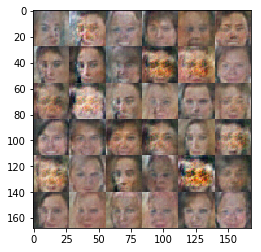

Epoch 1/1,  Step 1620	 Discriminator loss: 1.1696	 Generator loss: 0.8144	
Epoch 1/1,  Step 1640	 Discriminator loss: 1.2465	 Generator loss: 1.3365	
Epoch 1/1,  Step 1660	 Discriminator loss: 1.0961	 Generator loss: 1.1144	
Epoch 1/1,  Step 1680	 Discriminator loss: 1.1120	 Generator loss: 0.9715	
Epoch 1/1,  Step 1700	 Discriminator loss: 0.9810	 Generator loss: 1.1408	


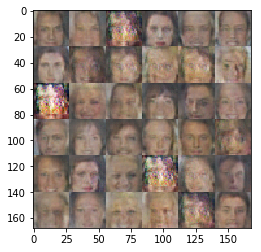

Epoch 1/1,  Step 1720	 Discriminator loss: 1.2138	 Generator loss: 1.6428	
Epoch 1/1,  Step 1740	 Discriminator loss: 1.1181	 Generator loss: 0.9472	
Epoch 1/1,  Step 1760	 Discriminator loss: 1.1070	 Generator loss: 1.1140	
Epoch 1/1,  Step 1780	 Discriminator loss: 1.1712	 Generator loss: 0.9794	
Epoch 1/1,  Step 1800	 Discriminator loss: 1.2501	 Generator loss: 1.4494	


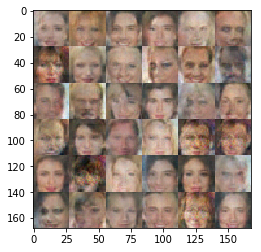

Epoch 1/1,  Step 1820	 Discriminator loss: 1.1453	 Generator loss: 1.3977	
Epoch 1/1,  Step 1840	 Discriminator loss: 1.1783	 Generator loss: 0.9644	
Epoch 1/1,  Step 1860	 Discriminator loss: 1.1180	 Generator loss: 1.1528	
Epoch 1/1,  Step 1880	 Discriminator loss: 1.1729	 Generator loss: 0.8758	
Epoch 1/1,  Step 1900	 Discriminator loss: 1.1653	 Generator loss: 0.8658	


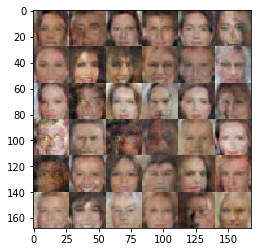

Epoch 1/1,  Step 1920	 Discriminator loss: 1.0350	 Generator loss: 1.3911	
Epoch 1/1,  Step 1940	 Discriminator loss: 1.2140	 Generator loss: 0.8345	
Epoch 1/1,  Step 1960	 Discriminator loss: 1.3363	 Generator loss: 0.6105	
Epoch 1/1,  Step 1980	 Discriminator loss: 1.1292	 Generator loss: 0.8658	
Epoch 1/1,  Step 2000	 Discriminator loss: 1.0670	 Generator loss: 1.0589	


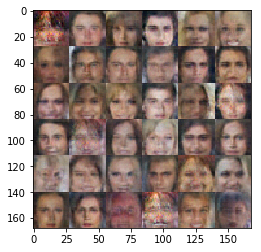

Epoch 1/1,  Step 2020	 Discriminator loss: 1.2926	 Generator loss: 0.6105	
Epoch 1/1,  Step 2040	 Discriminator loss: 1.0680	 Generator loss: 0.9912	
Epoch 1/1,  Step 2060	 Discriminator loss: 0.9553	 Generator loss: 1.1742	
Epoch 1/1,  Step 2080	 Discriminator loss: 1.2868	 Generator loss: 0.7634	
Epoch 1/1,  Step 2100	 Discriminator loss: 1.1438	 Generator loss: 1.2107	


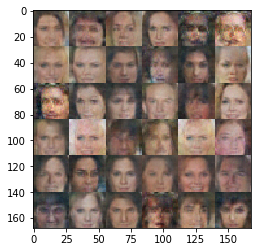

Epoch 1/1,  Step 2120	 Discriminator loss: 0.9636	 Generator loss: 1.2878	
Epoch 1/1,  Step 2140	 Discriminator loss: 1.0154	 Generator loss: 1.4803	
Epoch 1/1,  Step 2160	 Discriminator loss: 1.1239	 Generator loss: 0.9610	
Epoch 1/1,  Step 2180	 Discriminator loss: 1.0485	 Generator loss: 1.7740	
Epoch 1/1,  Step 2200	 Discriminator loss: 1.1653	 Generator loss: 0.9899	


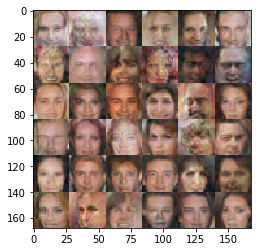

Epoch 1/1,  Step 2220	 Discriminator loss: 1.0970	 Generator loss: 1.2658	
Epoch 1/1,  Step 2240	 Discriminator loss: 0.9979	 Generator loss: 1.1509	
Epoch 1/1,  Step 2260	 Discriminator loss: 1.1808	 Generator loss: 0.8158	
Epoch 1/1,  Step 2280	 Discriminator loss: 1.3577	 Generator loss: 0.6793	
Epoch 1/1,  Step 2300	 Discriminator loss: 1.0759	 Generator loss: 0.9824	


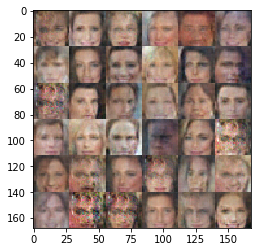

Epoch 1/1,  Step 2320	 Discriminator loss: 1.3354	 Generator loss: 0.6420	
Epoch 1/1,  Step 2340	 Discriminator loss: 1.0942	 Generator loss: 1.4691	
Epoch 1/1,  Step 2360	 Discriminator loss: 0.9496	 Generator loss: 1.3426	
Epoch 1/1,  Step 2380	 Discriminator loss: 0.8788	 Generator loss: 1.4899	
Epoch 1/1,  Step 2400	 Discriminator loss: 1.0079	 Generator loss: 1.1567	


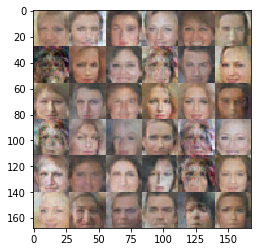

Epoch 1/1,  Step 2420	 Discriminator loss: 0.9625	 Generator loss: 1.5506	
Epoch 1/1,  Step 2440	 Discriminator loss: 1.2198	 Generator loss: 0.7281	
Epoch 1/1,  Step 2460	 Discriminator loss: 1.1386	 Generator loss: 0.8182	
Epoch 1/1,  Step 2480	 Discriminator loss: 1.1257	 Generator loss: 1.0823	
Epoch 1/1,  Step 2500	 Discriminator loss: 0.8943	 Generator loss: 1.5352	


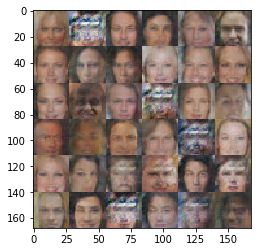

Epoch 1/1,  Step 2520	 Discriminator loss: 1.2501	 Generator loss: 0.7145	
Epoch 1/1,  Step 2540	 Discriminator loss: 1.1058	 Generator loss: 2.2368	
Epoch 1/1,  Step 2560	 Discriminator loss: 1.2434	 Generator loss: 0.6401	
Epoch 1/1,  Step 2580	 Discriminator loss: 1.1303	 Generator loss: 0.8334	
Epoch 1/1,  Step 2600	 Discriminator loss: 1.1756	 Generator loss: 0.7706	


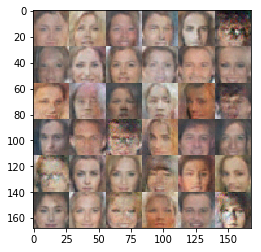

Epoch 1/1,  Step 2620	 Discriminator loss: 1.1105	 Generator loss: 0.7791	
Epoch 1/1,  Step 2640	 Discriminator loss: 1.1097	 Generator loss: 1.1349	
Epoch 1/1,  Step 2660	 Discriminator loss: 0.9621	 Generator loss: 1.1963	
Epoch 1/1,  Step 2680	 Discriminator loss: 0.9545	 Generator loss: 1.6091	
Epoch 1/1,  Step 2700	 Discriminator loss: 0.8702	 Generator loss: 2.1836	


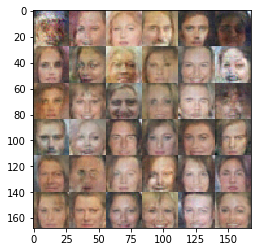

Epoch 1/1,  Step 2720	 Discriminator loss: 1.1582	 Generator loss: 0.7491	
Epoch 1/1,  Step 2740	 Discriminator loss: 0.8662	 Generator loss: 1.5933	
Epoch 1/1,  Step 2760	 Discriminator loss: 0.9809	 Generator loss: 1.3206	
Epoch 1/1,  Step 2780	 Discriminator loss: 1.1138	 Generator loss: 0.8070	
Epoch 1/1,  Step 2800	 Discriminator loss: 1.1180	 Generator loss: 0.8718	


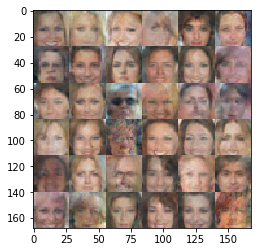

Epoch 1/1,  Step 2820	 Discriminator loss: 1.0504	 Generator loss: 1.0140	
Epoch 1/1,  Step 2840	 Discriminator loss: 1.1529	 Generator loss: 1.5072	
Epoch 1/1,  Step 2860	 Discriminator loss: 1.1025	 Generator loss: 1.4356	
Epoch 1/1,  Step 2880	 Discriminator loss: 1.2240	 Generator loss: 0.7479	
Epoch 1/1,  Step 2900	 Discriminator loss: 0.9203	 Generator loss: 1.4355	


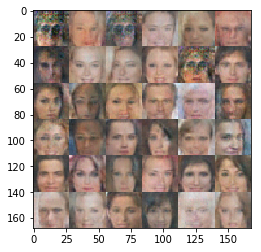

Epoch 1/1,  Step 2920	 Discriminator loss: 1.2749	 Generator loss: 0.6720	
Epoch 1/1,  Step 2940	 Discriminator loss: 1.0683	 Generator loss: 0.8521	
Epoch 1/1,  Step 2960	 Discriminator loss: 0.9563	 Generator loss: 1.1461	
Epoch 1/1,  Step 2980	 Discriminator loss: 1.5429	 Generator loss: 1.7293	
Epoch 1/1,  Step 3000	 Discriminator loss: 1.3474	 Generator loss: 0.5972	


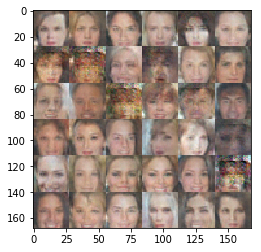

Epoch 1/1,  Step 3020	 Discriminator loss: 1.1771	 Generator loss: 1.0949	
Epoch 1/1,  Step 3040	 Discriminator loss: 0.8480	 Generator loss: 1.5504	
Epoch 1/1,  Step 3060	 Discriminator loss: 1.2914	 Generator loss: 0.6891	
Epoch 1/1,  Step 3080	 Discriminator loss: 1.0931	 Generator loss: 1.1557	
Epoch 1/1,  Step 3100	 Discriminator loss: 1.3235	 Generator loss: 2.5546	


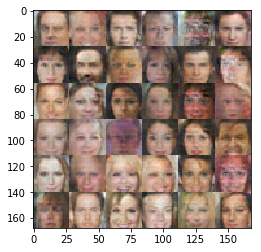

Epoch 1/1,  Step 3120	 Discriminator loss: 1.5400	 Generator loss: 0.6856	
Epoch 1/1,  Step 3140	 Discriminator loss: 1.2229	 Generator loss: 0.8124	
Epoch 1/1,  Step 3160	 Discriminator loss: 1.1872	 Generator loss: 0.9102	


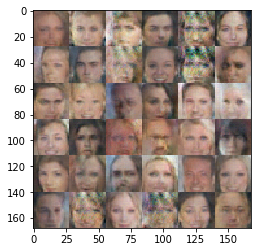

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.